# Airlines delays, can we avoid them?
## by Carolina Negrelli

## Investigation Overview

In this research I wanted to see how delays are distributed and if there is any feature that correlates with them. 

## Dataset Overview

This data set contains information about 7.5 million flights in USA for 2019. It has a lot of basic information such as Date, Time, Airline, Delays and Cancellations. I had remove 55 points with really large delay times.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe

all_files = glob.glob("data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


In [17]:
#data wrangling
flights = frame[['Month','DayofMonth','DayOfWeek','DepTime','CRSDepTime','ArrTime','CRSArrTime','Reporting_Airline','Flight_Number_Reporting_Airline','Tail_Number','ActualElapsedTime','CRSElapsedTime','AirTime','ArrDelay','DepDelay','Origin','Dest','Distance','TaxiIn','TaxiOut','Cancelled','CancellationCode','Diverted','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']]
flights.drop(['DepTime','ArrTime'],axis=1,inplace=True)
flights['Flight_Number_Reporting_Airline']=flights['Flight_Number_Reporting_Airline'].astype('str') 
flights['Cancelled']=flights['Cancelled'].astype('int')
flights['Diverted']=flights['Diverted'].astype('int')

In [18]:
#data wrangling
flights = flights[(flights.ArrDelay <= 1600) & (flights.DepDelay <= 1600)]

## Distribution of delays

 The distribution is bimodal, we can see the firt and biggest peak in the top plot and a second and small one in the second plot. 
- Most of the delays are around 20 min
- For the really large delays there is a little peak around 15hs 

We are considering that there is an actual delay when the delay is above 5 min.

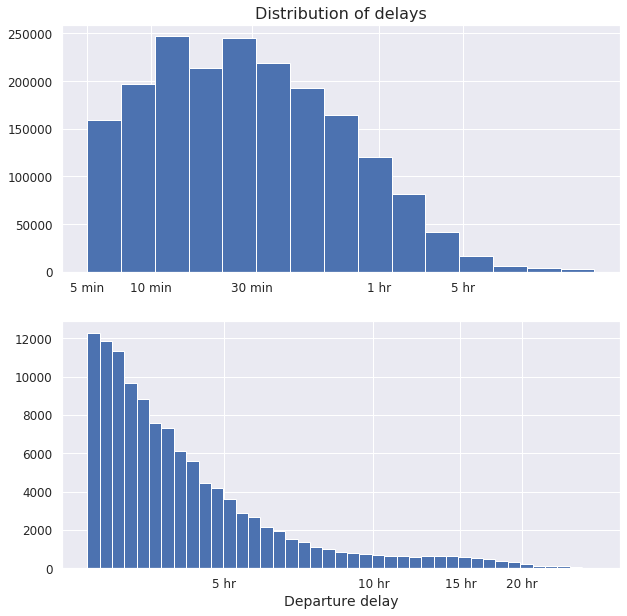

In [99]:
log_binsize = 0.16
bins = 10 ** np.arange(np.log10(5), np.log10(1000)+log_binsize, log_binsize)

plt.figure(figsize=[10, 10])
plt.subplot(2,1,1)
plt.hist(data = flights, x = 'DepDelay', bins = bins)
plt.xscale('log')
plt.xticks([5,10,30,120,300], ['5 min','10 min', '30 min', '1 hr','5 hr'],fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of delays',fontsize=16)
#plt.xlabel('Departure delay',fontsize=14)

plt.subplot(2,1,2)
log_binsize = 0.025
bins = 10 ** np.arange(2.2, np.log10(flights['DepDelay'].max())+log_binsize, log_binsize)


plt.hist(data = flights, x = 'DepDelay', bins = bins)
plt.xscale('log')
plt.xticks([300,600, 900, 1200], ['5 hr', '10 hr', '15 hr', '20 hr'],fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Distribution of very long delay times',fontsize=16)
plt.xlabel('Departure delay',fontsize=14);


## Airlines vs Departure Delays

Airlines B6 (JetBlue Airways) and  EV (Atlantic Southeast Airlines) have the biggest means of departure delay. 

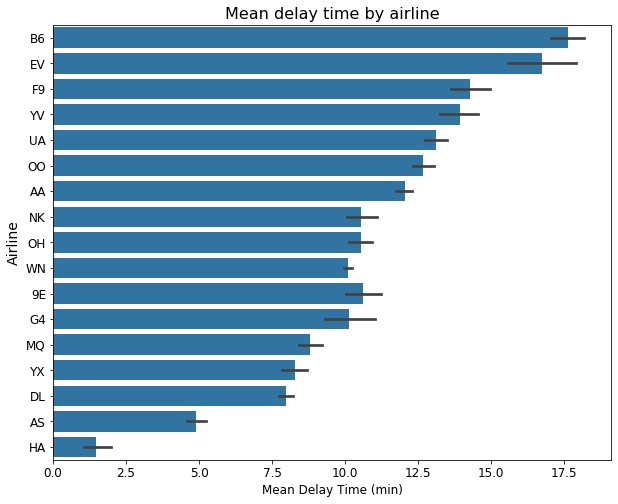

In [33]:
base_color = sb.color_palette()[0]
order2 = flights.groupby(['Reporting_Airline']).DepDelay.mean().sort_values(ascending=False).index
plt.figure(figsize=[10,8])

sb.barplot(data=flights.sample(1000000), y='Reporting_Airline',x='DepDelay',order=order2,color=base_color)
plt.title('Mean delay time by airline',fontsize=16)
plt.xlabel('Mean Delay Time (min)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Airline',fontsize=14);

## City vs Deaparture Delay
If we keep only the airports with most departure flights we can see that EWR (New York City) has the biggest mean in delays. 

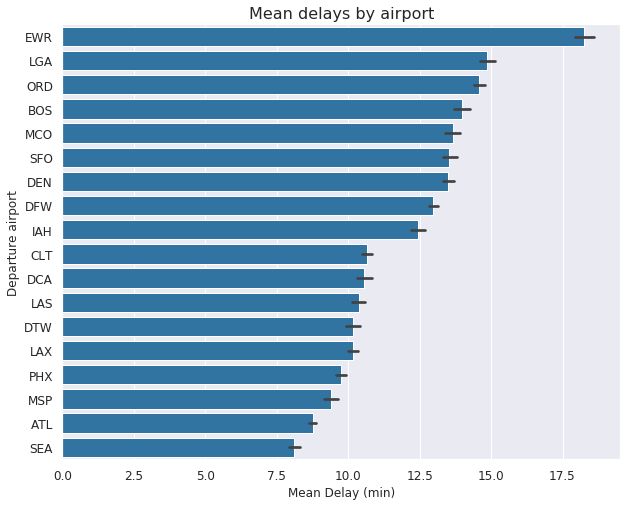

In [100]:
plt.figure(figsize=[10,8])
cities = flights.Origin.value_counts().head(18).index.tolist()
flights_cities = flights[flights.Origin.isin(cities)]
order4 = flights_cities.groupby(['Origin']).DepDelay.mean().sort_values(ascending=False).index
sb.barplot(data=flights_cities, y='Origin',x='DepDelay',color=base_color, order=order4)
plt.title('Mean delays by airport',fontsize=16)
plt.xlabel('Mean Delay (min)',fontsize=12)
plt.ylabel('Departure airport',fontsize=12);

## Date vs Departure Delay
There are some combinations of month and day of week that we should avoid because they have the biggest mean delays:
- May and Thursdays
- June and Sundays
- July and Thursdays
- November and Mondays
- December and Mondays

On the other hand, if you need to travel on February or August you should choose Saturdays;  and on March, Tuesdays.


In [19]:
flights['DayOfWeek']=flights.DayOfWeek.astype('str').replace({'1':'Monday','2':'Tuesday', '3':'Wednesday','4':'Thursday','5':'Friday','6':'Saturday','7':'Sunday'},)

In [20]:
days = pd.api.types.CategoricalDtype(ordered = True, categories = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
flights['DayOfWeek'] = flights.DayOfWeek.astype(days)

In [21]:
flights['Month']=flights.Month.astype('str').replace({'1':'January','2':'February', '3':'March','4':'April','5':'May','6':'June','7':'July','8':'August', '9':'September','10':'October','11':'November','12':'December'},)
months = pd.api.types.CategoricalDtype(ordered = True, categories = ['January','February', 'March','April','May','June','July','August', 'September','October','November','December'])
flights['Month'] = flights.Month.astype(months)

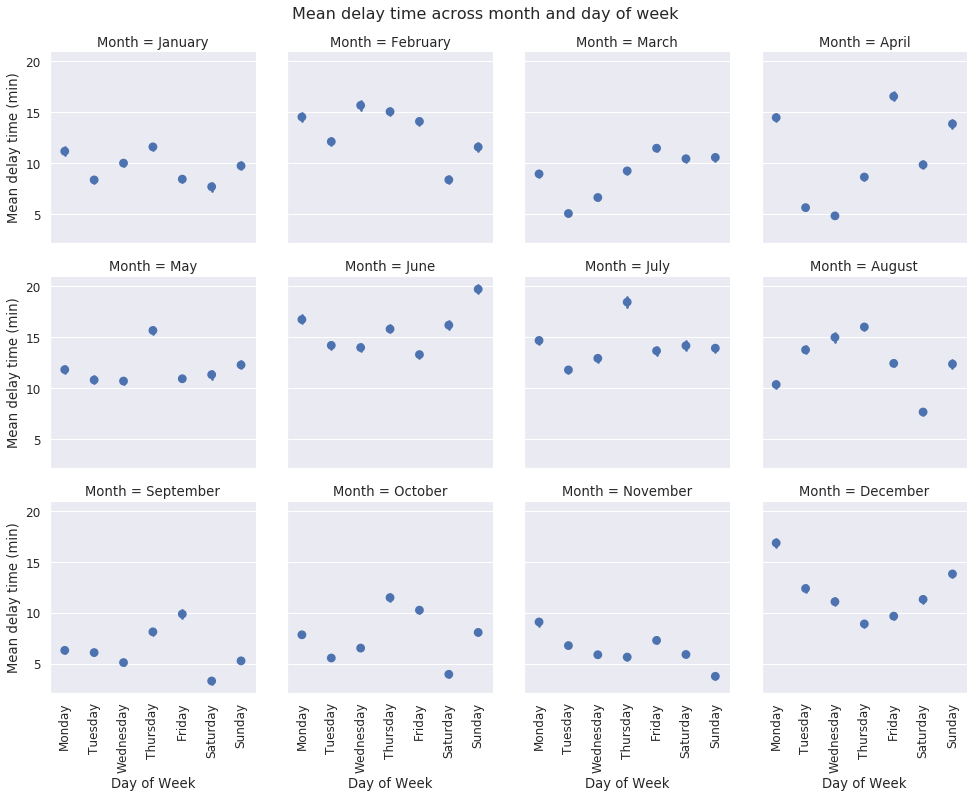

In [98]:
sb.set(font_scale=1.1)
g=sb.FacetGrid(data = flights, col = 'Month', col_wrap=4, size=3.5)
g.map(sb.pointplot, 'DayOfWeek', 'DepDelay', linestyles="")
g.set_xlabels('Day of Week')
g.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],rotation = 90)
g.set_ylabels('Mean delay (min)')
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Mean delays across month and day of week', fontsize=16)
plt.show();